In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660544 sha256=fc456349a5ed5e1b9262770bdd9dab7c02f33163ed1e1620e7ef4c068a2a0d95
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:658: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None


Epoch 1/50, Loss: 0.078407, LR: 0.000100
Epoch 2/50, Loss: 0.074671, LR: 0.000100
Epoch 3/50, Loss: 0.071510, LR: 0.000100
Epoch 4/50, Loss: 0.071601, LR: 0.000099
Epoch 5/50, Loss: 0.075897, LR: 0.000098


<ipython-input-2-80b4488ea110>:108: RuntimeWarning: overflow encountered in square
  v = beta2 * v + (1 - beta2) * (grad ** 2)
<ipython-input-2-80b4488ea110>:111: RuntimeWarning: invalid value encountered in divide
  update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
<ipython-input-2-80b4488ea110>:135: RuntimeWarning: overflow encountered in square
  return np.mean(error**2)
<ipython-input-2-80b4488ea110>:132: RuntimeWarning: invalid value encountered in subtract
  self.bn2_gamma -= learning_rate * bn2_gamma_grad
<ipython-input-2-80b4488ea110>:133: RuntimeWarning: invalid value encountered in subtract
  self.bn2_beta -= learning_rate * bn2_beta_grad


Epoch 6/50, Loss: inf, LR: 0.000098
Epoch 7/50, Loss: inf, LR: 0.000096
Epoch 8/50, Loss: inf, LR: 0.000095
Epoch 9/50, Loss: inf, LR: 0.000094
Epoch 10/50, Loss: inf, LR: 0.000092
Epoch 11/50, Loss: inf, LR: 0.000090


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Epoch 12/50, Loss: inf, LR: 0.000089
Epoch 13/50, Loss: inf, LR: 0.000086
Epoch 14/50, Loss: 0.112486, LR: 0.000084
Epoch 15/50, Loss: 0.112486, LR: 0.000082
Epoch 16/50, Loss: 0.112486, LR: 0.000079
Epoch 17/50, Loss: 0.112486, LR: 0.000077
Epoch 18/50, Loss: 0.112486, LR: 0.000074
Epoch 19/50, Loss: 0.112486, LR: 0.000071
Epoch 20/50, Loss: 0.112486, LR: 0.000068
Epoch 21/50, Loss: 0.112486, LR: 0.000065
Epoch 22/50, Loss: 0.112486, LR: 0.000062
Epoch 23/50, Loss: 0.112486, LR: 0.000059
Epoch 24/50, Loss: 0.112486, LR: 0.000056
Epoch 25/50, Loss: 0.112486, LR: 0.000053
Epoch 26/50, Loss: 0.112486, LR: 0.000050
Epoch 27/50, Loss: 0.112486, LR: 0.000047
Epoch 28/50, Loss: 0.112486, LR: 0.000044
Epoch 29/50, Loss: 0.112486, LR: 0.000041
Epoch 30/50, Loss: 0.112486, LR: 0.000038
Epoch 31/50, Loss: 0.112486, LR: 0.000035
Epoch 32/50, Loss: 0.112486, LR: 0.000032
Epoch 33/50, Loss: 0.112486, LR: 0.000029
Epoch 34/50, Loss: 0.112486, LR: 0.000026
Epoch 35/50, Loss: 0.112486, LR: 0.000023
Ep

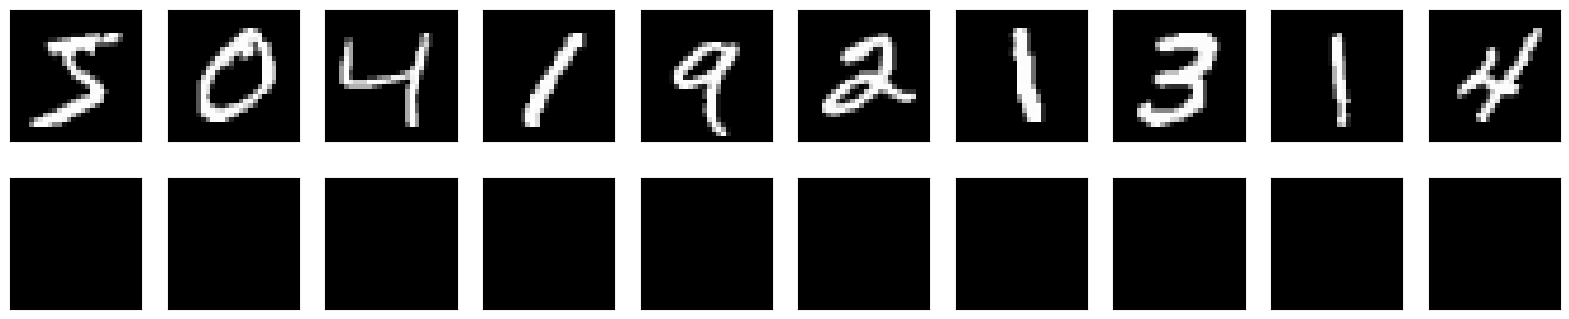

In [2]:

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
images = mnist.data.astype(np.float32) / 255.0
images = np.ascontiguousarray(images)

# CUDA kernel for forward and backward pass with ReLU and batch normalization
mod = SourceModule("""
__global__ void forward_pass(float *input, float *weights, float *output, float *bn_mean, float *bn_var, float *bn_gamma, float *bn_beta, int input_size, int output_size)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < output_size) {
        float sum = 0;
        for (int i = 0; i < input_size; i++) {
            sum += input[i] * weights[idx * input_size + i];
        }
        // Batch normalization
        sum = (sum - bn_mean[idx]) / sqrt(bn_var[idx] + 1e-5);
        sum = bn_gamma[idx] * sum + bn_beta[idx];
        // ReLU activation
        output[idx] = fmaxf(sum, 0);
    }
}

__global__ void backward_pass(float *input, float *weights, float *output, float *output_grad, float *input_grad, float *weight_grad, float *bn_gamma_grad, float *bn_beta_grad, float *bn_mean, float *bn_var, float *bn_gamma, float *bn_beta, int input_size, int output_size)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < input_size) {
        float sum = 0;
        for (int i = 0; i < output_size; i++) {
            float bn_grad = output_grad[i] * (output[i] > 0 ? 1 : 0);  // ReLU gradient
            bn_grad *= bn_gamma[i] / sqrt(bn_var[i] + 1e-5);
            sum += bn_grad * weights[i * input_size + idx];
            atomicAdd(&weight_grad[i * input_size + idx], bn_grad * input[idx]);
            atomicAdd(&bn_gamma_grad[i], output_grad[i] * (output[i] - bn_beta[i]) / bn_gamma[i]);
            atomicAdd(&bn_beta_grad[i], output_grad[i]);
        }
        input_grad[idx] = sum;
    }
}
""")

forward_pass = mod.get_function("forward_pass")
backward_pass = mod.get_function("backward_pass")

def run_forward(input_data, weights, output_size, bn_mean, bn_var, bn_gamma, bn_beta):
    output = np.zeros(output_size, dtype=np.float32)
    forward_pass(
        cuda.In(input_data), cuda.In(weights), cuda.Out(output),
        cuda.In(bn_mean), cuda.In(bn_var), cuda.In(bn_gamma), cuda.In(bn_beta),
        np.int32(input_data.shape[0]), np.int32(output_size),
        block=(256, 1, 1), grid=((output_size + 255) // 256, 1)
    )
    return output

def run_backward(input_data, weights, output, output_grad, input_size, output_size, bn_mean, bn_var, bn_gamma, bn_beta):
    input_grad = np.zeros(input_size, dtype=np.float32)
    weight_grad = np.zeros((output_size, input_size), dtype=np.float32)
    bn_gamma_grad = np.zeros(output_size, dtype=np.float32)
    bn_beta_grad = np.zeros(output_size, dtype=np.float32)
    backward_pass(
        cuda.In(input_data), cuda.In(weights), cuda.In(output), cuda.In(output_grad),
        cuda.Out(input_grad), cuda.Out(weight_grad), cuda.Out(bn_gamma_grad), cuda.Out(bn_beta_grad),
        cuda.In(bn_mean), cuda.In(bn_var), cuda.In(bn_gamma), cuda.In(bn_beta),
        np.int32(input_size), np.int32(output_size),
        block=(256, 1, 1), grid=((input_size + 255) // 256, 1)
    )
    return input_grad, weight_grad, bn_gamma_grad, bn_beta_grad

class Autoencoder:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weights1 = np.random.randn(hidden_size, input_size).astype(np.float32) * np.sqrt(2.0 / input_size)
        self.weights2 = np.random.randn(input_size, hidden_size).astype(np.float32) * np.sqrt(2.0 / hidden_size)
        self.bn1_mean = np.zeros(hidden_size, dtype=np.float32)
        self.bn1_var = np.ones(hidden_size, dtype=np.float32)
        self.bn1_gamma = np.ones(hidden_size, dtype=np.float32)
        self.bn1_beta = np.zeros(hidden_size, dtype=np.float32)
        self.bn2_mean = np.zeros(input_size, dtype=np.float32)
        self.bn2_var = np.ones(input_size, dtype=np.float32)
        self.bn2_gamma = np.ones(input_size, dtype=np.float32)
        self.bn2_beta = np.zeros(input_size, dtype=np.float32)

        # Adam optimizer parameters
        self.m1, self.v1 = np.zeros_like(self.weights1), np.zeros_like(self.weights1)
        self.m2, self.v2 = np.zeros_like(self.weights2), np.zeros_like(self.weights2)
        self.t = 0

    def forward(self, x):
        self.hidden = run_forward(x, self.weights1, self.hidden_size, self.bn1_mean, self.bn1_var, self.bn1_gamma, self.bn1_beta)
        self.output = run_forward(self.hidden, self.weights2, self.input_size, self.bn2_mean, self.bn2_var, self.bn2_gamma, self.bn2_beta)
        return self.output

    def backward(self, x, output_grad):
        hidden_grad, weight2_grad, bn2_gamma_grad, bn2_beta_grad = run_backward(self.hidden, self.weights2, self.output, output_grad, self.hidden_size, self.input_size, self.bn2_mean, self.bn2_var, self.bn2_gamma, self.bn2_beta)
        _, weight1_grad, bn1_gamma_grad, bn1_beta_grad = run_backward(x, self.weights1, self.hidden, hidden_grad, self.input_size, self.hidden_size, self.bn1_mean, self.bn1_var, self.bn1_gamma, self.bn1_beta)
        return weight1_grad, weight2_grad, bn1_gamma_grad, bn1_beta_grad, bn2_gamma_grad, bn2_beta_grad

    def adam_update(self, grad, m, v, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        return update, m, v

    def train(self, x, learning_rate, l2_reg=1e-5):
        self.t += 1
        output = self.forward(x)
        error = output - x
        weight1_grad, weight2_grad, bn1_gamma_grad, bn1_beta_grad, bn2_gamma_grad, bn2_beta_grad = self.backward(x, error)

        # L2 regularization
        weight1_grad += l2_reg * self.weights1
        weight2_grad += l2_reg * self.weights2

        # Adam updates
        w1_update, self.m1, self.v1 = self.adam_update(weight1_grad, self.m1, self.v1, self.t, learning_rate)
        w2_update, self.m2, self.v2 = self.adam_update(weight2_grad, self.m2, self.v2, self.t, learning_rate)

        self.weights1 -= w1_update
        self.weights2 -= w2_update
        self.bn1_gamma -= learning_rate * bn1_gamma_grad
        self.bn1_beta -= learning_rate * bn1_beta_grad
        self.bn2_gamma -= learning_rate * bn2_gamma_grad
        self.bn2_beta -= learning_rate * bn2_beta_grad

        return np.mean(error**2)

# Training loop
autoencoder = Autoencoder(784, 256)
epochs = 50
batch_size = 128
initial_learning_rate = 0.0001

for epoch in range(epochs):
    total_loss = 0
    # Cosine annealing learning rate schedule
    learning_rate = initial_learning_rate * (1 + np.cos(epoch * np.pi / epochs)) / 2

    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = np.ascontiguousarray(batch)
        loss = autoencoder.train(batch, learning_rate)
        total_loss += loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/(len(images)//batch_size):.6f}, LR: {learning_rate:.6f}")

# Visualize results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    input_image = np.ascontiguousarray(images[i])
    plt.imshow(autoencoder.forward(input_image).reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()